#### Customer Analysis
##### column name and dataframe name has been de-identification.

In [1]:
import os.path
import pandas as pd
import numpy as np
import copy
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve #P-R Curve
from sklearn import metrics
from sklearn.model_selection import GridSearchCV #Hyperparameters

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
DW_AMLALERT = pd.read_csv(r"/home/user/ALERT.csv", header=None, dtype=str)
DW_AMLALERT.columns = ['ALERT_ID', 'CUST_KEY', 'CUST_ID', 'CUST_DUP_NO', 'ALERT_DATE', 'ALERT_LEVEL', 'ALERT_SN']

OBU = pd.read_csv(r"/home/user/OBU.csv", dtype=str)

In [ ]:
# DW_AMLALERT 與主table merge的時候改成計算ALERT的次數
# DW_AMLALERT have to be pre-processed, otherwise the join would fail

# Add a new column: ALERT_MONTH
DW_AMLALERT["ALERT_DATE"] = pd.to_datetime(DW_AMLALERT["ALERT_DATE"])

DW_AMLALERT['CUST_DUP_NO'] = DW_AMLALERT['CUST_DUP_NO'].astype(object)

In [ ]:
# JOIN OBU & AMLALERT
OBU['CYC_MN'] = pd.to_datetime(OBU['CYC_MN'])
temp = pd.merge(DW_AMLALERT, OBU, on=['CUST_ID', 'CUST_DUP_NO'], how='inner')
temp = temp[['CUST_ID', 'CUST_DUP_NO', 'ALERT_DATE']]
temp.drop_duplicates(subset=['CUST_ID', 'CUST_DUP_NO'], keep='first', inplace=True)
# Count each CYC_MN 之前有發生幾次ALERT

OBU['ALERT_COUNT'] = 0
for i, j in zip(temp['CUST_ID'], temp['CUST_DUP_NO']):
    # Calculate Unique Months
    dates = OBU[(OBU['CUST_ID'] == i) & (OBU['CUST_DUP_NO'] == j)]['CYC_MN'].unique()
    OBU_temp = OBU[(OBU['CUST_ID'] == i) & (OBU['CUST_DUP_NO'] == j)][['CUST_ID', 'CUST_DUP_NO', 'CYC_MN']]
    DW_AMLALERT_temp = DW_AMLALERT[(DW_AMLALERT['CUST_ID'] == i) & (DW_AMLALERT['CUST_DUP_NO'] == j)]
    alert_counts = []
    
    for date in dates:
        if len(DW_AMLALERT_temp[DW_AMLALERT_temp['ALERT_DATE'] < date]) >0:
            alert_count = len(DW_AMLALERT_temp[DW_AMLALERT_temp['ALERT_DATE'] < date].drop_duplicates(subset=['ALERT_SN'], keep='first'))
            OBU.loc[(OBU['CUST_ID'] == i) & (OBU['CUST_DUP_NO'] == j) & (OBU['CYC_MN'] == date), 'ALERT_COUNT'] = alert_count
        else:
            continue


In [ ]:
# SAR: 非 Y即 N
OBU['SAR'] = np.where(OBU['SAR'] == 'Y', 'Y', 'N')

#### Remove Non Changing Data

In [10]:
use_cols = ['CUST_ID', 'CUST_DUP_NO'] + ['SAR']
OBU = OBU.sort_values('CYC_MN', ascending=False).drop_duplicates(subset=use_cols, keep='first')
OBU.reset_index(inplace=True)

In [11]:
OBU['CYC_MN'].value_counts(dropna=False)

2020-08-01    15380
2019-09-01       79
2019-11-01       72
2019-10-01       71
2020-02-01       64
2020-03-01       53
2020-07-01       52
2020-01-01       48
2020-06-01       47
2019-12-01       45
2020-05-01       44
2020-04-01       40
Name: CYC_MN, dtype: int64

#### Data Transformation
##### 1. Categorical
##### 1.1 Original Categorical

In [10]:
# 需先經過轉換的變數
# 1. CMFCUS1_AML_BUSINESS
def apply_CMFCUS1_AML_BUSINESS(series):
    input = series['CMFCUS1_AML_BUSINESS']
    if (input in ['01', '02', '03', '04', '05', '06', '07', '08']):
        return 'Y'
    else:
        return 'N'

OBU['CMFCUS1_AML_BUSINESS'] = OBU.apply(apply_CMFCUS1_AML_BUSINESS, axis=1)


for i in ['DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 'CD_FG', 'OT_FG']:
    OBU[i] = np.where(OBU[i] == 'V', 'Y', 'N')

    

# 2. CMFCUS25_AE_TYPE
# Turn Na into 'N'; other into 'Y'
OBU['CMFCUS25_AE_TYPE'] = np.where((OBU["CMFCUS25_AE_TYPE"].isin(['1', '2', '3', '4', '5', '6', '7'])), 'Y', 'N')




# 全部Categorical變數
# 非 Y or N 即 N

X_Categorical = ['CMFCUS1_VIP_CODE', 'CMFCUS1_BUSINESS_FLAG', 'CMFCUS1_NOTAX_FLAG', 'CMFCUS1_FINANCIAL_ACT', 
                 'CMFCUS1_AML_BUSINESS', 'DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 
                 'CD_FG', 'OT_FG', 'TRUST_YN', 'CONFIRM_YN', 'COMPLEX_CS_FG', 'AUTHORIZED', 'BEARER_SHARE', 
                 'ISSUE_BEARER', 'SOLE_CORP', 'TRUST_HOLDER', 'CUST_PANA', 'CUST_THIRD', 'CUST_ADVRS', 
                 'CUST_BAHA', 'CUST_PARA', 'CMFCUS25_AE_TYPE', 'CMFCUS25_FOREIGN_COMPANY', 'CMFCUS25_FOREIGN_ENTITY', 
                 'CMFCUS25_CERTI_FLAG', 'CMFCUS25_TAXFREE_FLAG', 'CMFCUS25_CREATIVE_FLAG', 'CMFCUS25_OSU_FLAG', 
                 'CMFCUS25_PUBLIC_CMPY']

for x in X_Categorical:
    OBU[x] = np.where(~OBU[x].isin(['Y', 'N']), 'N', OBU[x])

##### 1.2 Numeric to Categorical

In [11]:
# 需先經過轉換的變數
# 1. PEP_COUNT
test = OBU[(OBU['PEP_1'] == 'Y') | (OBU['PEP_2'] == 'Y') | (OBU['PEP_3'] == 'Y') | (OBU['PEP_4'] == 'Y')][['PEP_1', 'PEP_2', 'PEP_3', 'PEP_4']]
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['PEP_COUNT'] = 0
OBU.loc[test2.index, 'PEP_COUNT'] = test2['Y']

# 2. REL_ADVERS_COUNT
test = OBU[(OBU['REL_ADVRS_1'] == 'Y') | (OBU['REL_ADVRS_2'] == 'Y') | (OBU['REL_ADVRS_3'] == 'Y') | (OBU['REL_ADVRS_4'] == 'Y') | (OBU['REL_ADVRS_5'] == 'Y') | 
          (OBU['REL_ADVRS_6'] == 'Y') | (OBU['REL_ADVRS_7'] == 'Y') | (OBU['REL_ADVRS_8'] == 'Y') | (OBU['REL_ADVRS_9'] == 'Y') | (OBU['REL_ADVRS_10'] == 'Y') |
          (OBU['REL_ADVRS_11'] == 'Y') | (OBU['REL_ADVRS_12'] == 'Y') | (OBU['REL_ADVRS_13'] == 'Y') | (OBU['REL_ADVRS_14'] == 'Y') | (OBU['REL_ADVRS_15'] == 'Y') | 
          (OBU['REL_ADVRS_16'] == 'Y') | (OBU['REL_ADVRS_17'] == 'Y') | (OBU['REL_ADVRS_18'] == 'Y') | (OBU['REL_ADVRS_19'] == 'Y') | (OBU['REL_ADVRS_20'] == 'Y')
          ][['REL_ADVRS_1', 'REL_ADVRS_2', 'REL_ADVRS_3', 'REL_ADVRS_4', 'REL_ADVRS_5', 'REL_ADVRS_6', 'REL_ADVRS_7', 'REL_ADVRS_8', 
            'REL_ADVRS_9', 'REL_ADVRS_10', 'REL_ADVRS_11', 'REL_ADVRS_12', 'REL_ADVRS_13', 'REL_ADVRS_14', 'REL_ADVRS_15', 'REL_ADVRS_16', 
            'REL_ADVRS_17', 'REL_ADVRS_18', 'REL_ADVRS_19', 'REL_ADVRS_20']] 
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['REL_ADVERS_COUNT'] = 0
OBU.loc[test2.index, 'REL_ADVERS_COUNT'] = test2['Y']

# 3. REL_PEPS_COUNT
test = OBU[(OBU['REL_PEPS_1'] == 'Y') | (OBU['REL_PEPS_2'] == 'Y') | (OBU['REL_PEPS_3'] == 'Y') | (OBU['REL_PEPS_4'] == 'Y') | (OBU['REL_PEPS_5'] == 'Y') | 
          (OBU['REL_PEPS_6'] == 'Y') | (OBU['REL_PEPS_7'] == 'Y') | (OBU['REL_PEPS_8'] == 'Y') | (OBU['REL_PEPS_9'] == 'Y') | (OBU['REL_PEPS_10'] == 'Y') |
          (OBU['REL_PEPS_11'] == 'Y') | (OBU['REL_PEPS_12'] == 'Y') | (OBU['REL_PEPS_13'] == 'Y') | (OBU['REL_PEPS_14'] == 'Y') | (OBU['REL_PEPS_15'] == 'Y') | 
          (OBU['REL_PEPS_16'] == 'Y') | (OBU['REL_PEPS_17'] == 'Y') | (OBU['REL_PEPS_18'] == 'Y') | (OBU['REL_PEPS_19'] == 'Y') | (OBU['REL_PEPS_20'] == 'Y')
          ][['REL_PEPS_1', 'REL_PEPS_2', 'REL_PEPS_3', 'REL_PEPS_4', 'REL_PEPS_5', 'REL_PEPS_6', 'REL_PEPS_7', 'REL_PEPS_8', 
            'REL_PEPS_9', 'REL_PEPS_10', 'REL_PEPS_11', 'REL_PEPS_12', 'REL_PEPS_13', 'REL_PEPS_14', 'REL_PEPS_15', 'REL_PEPS_16', 
            'REL_PEPS_17', 'REL_PEPS_18', 'REL_PEPS_19', 'REL_PEPS_20']] 
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
OBU['REL_PEPS_COUNT'] = 0
OBU.loc[test2.index, 'REL_PEPS_COUNT'] = test2['Y']

X_Numeric = ['CMFCUS1_ADR_CNT', 'CMFCUS1_MPHONE_CNT', 'CMFCUS1_OPHONE_CNT', 
             'PEP_COUNT', 'REL_ADVERS_COUNT', 'REL_PEPS_COUNT']

# 全部 Numeric 變數
# 非 數字 即 0
X_Numeric = ['CMFCUS1_ADR_CNT', 'CMFCUS1_MPHONE_CNT', 'CMFCUS1_OPHONE_CNT', 
             'PEP_COUNT', 'REL_ADVERS_COUNT', 'REL_PEPS_COUNT']

for col in X_Numeric:
    OBU[col] = OBU[col].fillna(0)
    

# Transform Numeric into Categorical

# 1.CMFCUS1_ADR_CNT; Threshold: 2
OBU['CMFCUS1_ADR_CNT'] = OBU['CMFCUS1_ADR_CNT'].astype(int)
# Create new column
OBU['CMFCUS1_ADR_CNT_THR_2'] = np.where(OBU['CMFCUS1_ADR_CNT'] >= 2, 'Y', 'N')

# 2. CMFCUS1_MPHONE_CNT; 
OBU['CMFCUS1_MPHONE_CNT'] = OBU['CMFCUS1_MPHONE_CNT'].astype(int)
# Create new column
OBU['CMFCUS1_MPHONE_CNT_THR_2'] = np.where(OBU['CMFCUS1_MPHONE_CNT'] >= 2, 'Y', 'N')

# 3. CMFCUS1_OPHONE_CNT
OBU['CMFCUS1_OPHONE_CNT'] = OBU['CMFCUS1_OPHONE_CNT'].astype(int)
# Create new column
OBU['CMFCUS1_OPHONE_CNT_THR_2'] = np.where(OBU['CMFCUS1_OPHONE_CNT'] >= 2, 'Y', 'N')

# 4. PEP_COUNT
# Create new column
OBU['PEP_COUNT_THR_1'] = np.where(OBU['PEP_COUNT'] >=1, 'Y', 'N')

# 5. REL_ADVERS_COUNT
# Create new column
OBU['REL_ADVERS_COUNT_THR_1'] = np.where(OBU['REL_ADVERS_COUNT'] >=1, 'Y', 'N')

# 6. REL_PEPS_COUNT
# Create new column
OBU['REL_PEPS_COUNT_THR_1'] = np.where(OBU['REL_PEPS_COUNT'] >=1, 'Y', 'N')


X_Categorical = X_Categorical + ['CMFCUS1_ADR_CNT_THR_2', 'CMFCUS1_MPHONE_CNT_THR_2', 'CMFCUS1_OPHONE_CNT_THR_2', 
                                 'PEP_COUNT_THR_1', 'REL_ADVERS_COUNT_THR_1', 'REL_PEPS_COUNT_THR_1']

# Turn 'Y', 'N' into 1, 0
for col in X_Categorical:
    OBU[col] = LabelEncoder().fit_transform(OBU[col])

##### 2. Ordinal

In [12]:
# 需先經過轉換的變數
# Remember that changing NA value into the lowest ranking in ordinal variables might cause issue and affect the model performation
# It should be adjusted to dummy variables in the second proposal.

# 1. CMFCUS1_BUSINESS_CODE
BUSINESS_CODE_TABLE = pd.read_csv(r"/home/user/BUSINESS_CODE_TABLE.csv", dtype=str) #行業編號對照風險等級表

# Create dictionary
BUSINESS_CODE_dict = {'L': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='L']['CODE'].tolist(),
                      'M': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='M']['CODE'].tolist(),
                      'H': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='H']['CODE'].tolist()}
# Inverse dictionary
BUSINESS_CODE_dict = {c: r for r, code in BUSINESS_CODE_dict.items() for c in code}

OBU['CMFCUS1_BUSINESS_CODE'].replace(BUSINESS_CODE_dict, inplace=True)
# Nan轉為L
OBU['CMFCUS1_BUSINESS_CODE'] = np.where(~OBU["CMFCUS1_BUSINESS_CODE"].isin(['H', 'M', 'L']), 'L', OBU['CMFCUS1_BUSINESS_CODE'])


# 2. LOCATION_CD & HEAD_OFFICE_CD 
# Create a new column: Nation_Risk to select the higher one between the two columns
NationRisk_Table = pd.read_excel(r"/home/user/NationRisk_Table.xlsx", dtype=str)

NationRisk_dict = {'1':NationRisk_Table[NationRisk_Table['洗錢風險評等']=='L']['國家代碼'].tolist(),
                   '2': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='ML']['國家代碼'].tolist(),
                   '3': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='M']['國家代碼'].tolist(),
                   '4': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='MH']['國家代碼'].tolist(),
                   '5': NationRisk_Table[NationRisk_Table['洗錢風險評等']=='H']['國家代碼'].tolist()}

# Inverse dictionary
NationRisk_dict = {c: r for r, code in NationRisk_dict.items() for c in code}

OBU['LOCATION_CD'].replace(NationRisk_dict, inplace=True)
OBU['HEAD_OFFICE_CD'].replace(NationRisk_dict, inplace=True)
# Nan or no matching 轉為H
OBU['LOCATION_CD'] = np.where(~OBU['LOCATION_CD'].isin(['1', '2', '3', '4', '5']), '5', OBU['LOCATION_CD'])
OBU['HEAD_OFFICE_CD'] = np.where(~OBU['HEAD_OFFICE_CD'].isin(['1', '2', '3', '4', '5']), '5', OBU['HEAD_OFFICE_CD'])

OBU['NATION_RISK'] = OBU[['LOCATION_CD', 'HEAD_OFFICE_CD']].max(axis=1).astype(int).astype(str)


# 3. AMT_RANGE
# Nan 轉為0
OBU['AMT_RANGE'] = np.where(~OBU["AMT_RANGE"].isin(['1', '2', '3']), '0', OBU['AMT_RANGE'])

# 4. OBU_ANNUAL_INCOME
# Nan 轉為0
OBU['OBU_ANNUAL_INCOME'] = np.where(~OBU["OBU_ANNUAL_INCOME"].isin(['1', '2', '3']), '0', OBU['OBU_ANNUAL_INCOME'])

# 5. L, M, H to number 1, 2, 3
def risk_to_number(series):
    input = series
    if input == 'H':
        return '3'
    elif input == 'M':
        return '2'
    else:
        return '1'

for i in ['CMFCUS1_BUSINESS_CODE', 'JOB_RISK']:
    OBU[i] = OBU[i].apply(risk_to_number)

# 5. CMFCUS25_SP_RATING
OBU['CMFCUS25_SP_RATING'] = OBU['CMFCUS25_SP_RATING'].map({np.nan: 1, 'D': 2, 'SD': 3, 'R': 4, 'CCC-': 5, 'CCC': 6, 
                                                           'CCC+': 7, 'B-': 8, 'B': 9, 'B+': 10, 'BB-': 11, 'BB': 12, 
                                                           'BB+': 13, 'BBB-': 14, 'BBB': 15, 'BBB+': 16, 'A-': 17, 
                                                           'A': 18, 'A+': 19, 'AA-': 20, 'AA': 21, 'AA+': 22, 'AAA': 23})
    
# 6. CMFCUS25_MOODYS_RATING
# Moody's has assigned (P)A1 ratings to the 1 billion preferred securities shelf registration of five Travelers Capital trusts
# Here I'll take it as the same level with A1
OBU['CMFCUS25_MOODYS_RATING'] = np.where(OBU['CMFCUS25_MOODYS_RATING'] == '(P)A1', 'A1', OBU['CMFCUS25_MOODYS_RATING'])

OBU['CMFCUS25_MOODYS_RATING'] = np.where(OBU['CMFCUS25_MOODYS_RATING'] == 'A3-', 'A3', OBU['CMFCUS25_MOODYS_RATING']) #Fix typo

OBU['CMFCUS25_MOODYS_RATING'] = OBU['CMFCUS25_MOODYS_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'Ca': 4, 'Caa3': 5, 'Caa2': 6, 
                                                                   'Caa1': 7, 'B3': 8, 'B2': 9, 'B1': 10, 'Ba3': 11, 'Ba2': 12, 
                                                                   'Ba1': 13, 'Baa3': 14, 'Baa2': 15, 'Baa1': 16, 'A3': 17, 
                                                                   'A2': 18, 'A1': 19, 'Aa3': 20, 'Aa2': 21, 'Aa1': 22, 'Aaa': 23})



# 7. CMFCUS25_SRT_SP_RATING
OBU['CMFCUS25_SRT_SP_RATING'] = OBU['CMFCUS25_SRT_SP_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'B': 4, 'A-3': 5, 
                                                                   'A-2': 6, 'A-1': 7, 'A-1+': 8})

# 8. CMFCUS25_SRT_MOODYS_RATING
OBU['CMFCUS25_SRT_MOODYS_RATING'] = OBU['CMFCUS25_SRT_MOODYS_RATING'].map({np.nan: 1, 'P-3': 2, 'P-2': 3, 'P-1': 4})

# 9. CMFCUS25_SRT_FITCH_RATING
OBU['CMFCUS25_SRT_FITCH_RATING'] = np.where(OBU['CMFCUS25_SRT_FITCH_RATING'] == 'F2-', 'F2', OBU['CMFCUS25_SRT_FITCH_RATING']) #Fix typo

OBU['CMFCUS25_SRT_FITCH_RATING'] = OBU['CMFCUS25_SRT_FITCH_RATING'].map({np.nan: 1, 'D': 2, 'C': 3, 'B': 4, 'F3': 5, 
                                                                         'F2': 6, 'F1': 7, 'F1+': 8})


# 全部Ordinal變數
X_Ordinal = ['CMFCUS1_BUSINESS_CODE', 'NATION_RISK', 'AMT_RANGE', 
             'OBU_ANNUAL_INCOME', 'JOB_RISK', 'CMFCUS25_SP_RATING', 'CMFCUS25_MOODYS_RATING', 
             'CMFCUS25_SRT_SP_RATING', 'CMFCUS25_SRT_MOODYS_RATING', 'CMFCUS25_SRT_FITCH_RATING']


##### 3. Dummy

In [13]:
from datetime import date
# 需先經過轉換的變數

# 1. CMFCUS1_BIRTH_DATE
OBU['CMFCUS1_BIRTH_DATE'] = pd.to_datetime(OBU['CMFCUS1_BIRTH_DATE'], errors='coerce') #if out of bounds then return NAT

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

OBU['CMFCUS1_BIRTH_DATE'] = OBU['CMFCUS1_BIRTH_DATE'].apply(calculate_age)

def apply_age(Series):
    input = Series
    if input < 3:
        return '0-3'
    elif (input >= 3) & (input < 5):
        return '3-5'
    elif (input >= 5) & (input < 10):
        return '5-10'
    elif input >= 10:
        return '>10'
    else:
        'NA_TYPE'

OBU['CMFCUS1_BIRTH_DATE'] = OBU['CMFCUS1_BIRTH_DATE'].apply(apply_age)


# 2. CMFCUS1_Q_ID
# 00, 01, 03, 10, 36, 49, 99都歸於NA_TYPE
OBU['CMFCUS1_Q_ID'] = np.where(OBU["CMFCUS1_Q_ID"].isin(['00', '01', '03', '10', '36', '49', '99', 'ZZ', np.nan]), 
                               'NA_TYPE', OBU["CMFCUS1_Q_ID"])

# 3. 'CMFCUS1_PURPOSE', 'CMFCUS1_DERIVATIVE', 'CMFCUS1_TITLE_CODE', 'LN_TYP', 'CONFIRM_TYPE', 'CMFCUS25_BRANCH'
# NA改成NA_TYPE
for i  in ['CMFCUS1_JOB_TITLE', 'CMFCUS1_PURPOSE', 'CMFCUS1_DERIVATIVE', 'CMFCUS1_TITLE_CODE', 'LN_TYP', 'CONFIRM_TYPE', 'CMFCUS25_BRANCH', 'CMFCUS25_FORE_CASH_FLAG']:
    OBU[i] =np.where(OBU[i].isna(), 'NA_TYPE', OBU[i])

# 4. CORP_TYPE
# 根據IssueLog Mega回覆: 共12類
# 1~9, A, Z, Nan: NA_TYPE

OBU['CORP_TYPE'] = np.where(OBU['CORP_TYPE'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', 'Z', 'A']), OBU['CORP_TYPE'], 'NA_TYPE')


# 全部Dummy變數
X_Dummy = ['CMFCUS1_BIRTH_DATE', 'CMFCUS1_JOB_TITLE', 'CMFCUS1_Q_ID','CMFCUS1_PURPOSE', 'CMFCUS1_DERIVATIVE', 'CMFCUS1_TITLE_CODE', 
           'CUST_TYP', 'LN_TYP', 'CONFIRM_TYPE', 'CORP_TYPE', 'CMFCUS25_BRANCH', 'CMFCUS25_FORE_CASH_FLAG', 'CHANNEL']


#### Variable Selection

##### 1. WOE & IV

In [16]:
# Python has no package calculating WOE & IV

def iv_woe(data, target, bins=10, show_woe=False):
    
    # Empty Dataframe
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    
    # Extract Column Names
    cols = data.columns
    
    # Run WOE & IV on all X variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') & (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        d = d0.groupby('x', as_index=False).agg({'y': ['count', 'sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(), 6)))
        
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)
        
        # Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF



data = OBU[X_Categorical + X_Ordinal + X_Dummy + ['SAR']]
data['SAR'] = LabelEncoder().fit_transform(data['SAR']) # Turn y into [0, 1]
# 轉換dummy變數
for each in X_Dummy:
    dummies = pd.get_dummies(data.loc[:, each], prefix=each)
    data = pd.concat([data, dummies], axis=1)

# Delete original dummy variable columns
data = data.drop(X_Dummy, axis=1)

iv, woe = iv_woe(data=data, target='SAR', bins=10, show_woe=False)

/opt/microsoft/mlserver/9.4.7/runtime/python/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# 0.02-0.1: the predictor has only a weak relationship to the Goods/Bads odds ration
# 0.1-0.3: the predictor has a medium strength relationship to the Goods/Bads odds ration
# 0.3-0.5: the predictor has a strong relationship to the Goods/Bads odds ration
# >0.5: suspicious relationship

# Select variable with IV larger than 0.1 
print(iv[iv["IV"] > 0.1])

                  Variable        IV
0    CMFCUS1_FINANCIAL_ACT  0.619099
0                    IX_FG  0.510050
0                    EB_FG  0.117921
0               CONFIRM_YN  0.950027
0      CMFCUS25_CERTI_FLAG  0.339558
0    CMFCUS1_ADR_CNT_THR_2  0.257596
0   REL_ADVERS_COUNT_THR_1  0.101929
0                AMT_RANGE  0.750026
0        OBU_ANNUAL_INCOME  0.369085
0        CMFCUS1_PURPOSE_E  0.133495
0  CMFCUS1_PURPOSE_NA_TYPE  0.354142
0           LN_TYP_NA_TYPE  0.137894
0           CONFIRM_TYPE_1  0.803638
0     CONFIRM_TYPE_NA_TYPE  0.950027
0              CORP_TYPE_4  0.170926
0        CORP_TYPE_NA_TYPE  0.639748
0              CORP_TYPE_Z  0.961433
0        CMFCUS25_BRANCH_0  0.590728
0  CMFCUS25_BRANCH_NA_TYPE  0.689674


##### 3. Check VIF

##### 先確認是否有不應該出現的變數(EX: 法人資料出現個人戶相關欄位)

In [19]:
# check IV > 0.1 variables' VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variables with VIF over 10 should be checked 
# Drop some columns with high VIF(The variables are changeable to find the best answer) 
X_trans = data[pd.Series.tolist(iv.loc[iv['IV'] >= 0.1, 'Variable'])]

# Remove the highest VIF column that are above 10
X_trans = X_trans.drop(['CONFIRM_YN', 'CONFIRM_TYPE_NA_TYPE', 'CORP_TYPE_NA_TYPE', 
                        'CMFCUS25_BRANCH_NA_TYPE', 'CORP_TYPE_Z', 'CMFCUS25_BRANCH_0', 'CMFCUS25_CERTI_FLAG'], axis=1)

# The calculating VIF function does not accept columns with string type
for col in X_trans.columns:
    X_trans.loc[:, col] = pd.to_numeric(X_trans[col])

vif_data = pd.DataFrame()
vif_data.loc[:, 'feature'] = X_trans.columns

# Calculating VIF for each feature
vif_data.loc[:, 'VIF'] = [variance_inflation_factor(X_trans.values, i) for i in range(len(X_trans.columns))]
print(vif_data)

                    feature       VIF
0     CMFCUS1_FINANCIAL_ACT  6.623131
1                     IX_FG  1.375159
2                     EB_FG  2.792329
3     CMFCUS1_ADR_CNT_THR_2  4.190917
4    REL_ADVERS_COUNT_THR_1  1.004793
5                 AMT_RANGE  6.570026
6         OBU_ANNUAL_INCOME  4.486303
7         CMFCUS1_PURPOSE_E  1.363934
8   CMFCUS1_PURPOSE_NA_TYPE  1.725202
9            LN_TYP_NA_TYPE  1.199634
10           CONFIRM_TYPE_1  5.464775
11              CORP_TYPE_4  1.722651


##### 3. Final Variable Selection

In [20]:
# Final Variables
X_col = X_trans.columns
X_col = X_col.tolist()

#### 2.1 Run Model with imbalancing data(Including ROC curve & recall score)

#### 整體資料跑 Cross-Validation

In [21]:
X = OBU

# 轉換dummy變數
for each in X_Dummy:
    dummies = pd.get_dummies(X.loc[:, each], prefix=each)
    X = pd.concat([X, dummies], axis=1)

y = X['SAR']
# Select Final Columns
X = X[X_col]


In [22]:
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
print(cross_val_score(logistic_regression, X, y, cv=skf))

[0.67833698 0.67427321 0.70053142 0.65270397 0.66614567]


In [22]:
# 每次的結果與其餘四次之95% Confidence Interval進行比對

outcome = [0.67833698, 0.67427321, 0.70053142, 0.65270397, 0.66614567]

# Function to calculate confidence interval
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2, n-1)
    return m-h, m+h

for i in range(0,5):
    temp = copy.deepcopy(outcome)
    comparison = temp.pop(i)
    print(comparison, confidence_interval(temp))


0.67833698 (0.6413535907826853, 0.7054735442173148)
0.67427321 (0.6421155440326516, 0.7067434759673485)
0.70053142 (0.6498730981732197, 0.6858568168267805)
0.65270397 (0.6564191801999799, 0.7032244598000201)
0.66614567 (0.6452787349550103, 0.7076440550449897)


In [23]:
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logistic_regression.fit(X_train, y_train)
    
    # Record Predict Outcome
    OBU.loc[test_index, 'pred'] = logistic_regression.predict(X_test)
    # Record Probability
    OBU.loc[test_index, 'pred_proba'] = logistic_regression.predict_proba(X_test)[:, 1].astype(float)
    print(OBU.iloc[test_index].groupby(['FINAL_CRR', 'SAR'])['pred_proba'].mean())

FINAL_CRR  SAR
H          N      0.376830
           Y      0.649173
L          N      0.338494
M          N      0.347651
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.357862
           Y      0.599564
L          N      0.337455
M          N      0.348242
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.374181
           Y      0.637516
L          N      0.297275
M          N      0.349676
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.379030
           Y      0.650012
L          N      0.299180
M          N      0.347875
Name: pred_proba, dtype: float64
FINAL_CRR  SAR
H          N      0.380572
           Y      0.614435
L          N      0.327429
M          N      0.351755
Name: pred_proba, dtype: float64


In [24]:
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logistic_regression.fit(X_train, y_train)
    
    # Record Predict Outcome
    OBU.loc[test_index, 'pred'] = logistic_regression.predict(X_test)
    # Record Probability
    OBU.loc[test_index, 'pred_proba'] = logistic_regression.predict_proba(X_test)[:, 1].astype(float)
    print(OBU.iloc[test_index].groupby(['FINAL_CRR'])['pred_proba'].mean())

FINAL_CRR
H    0.384499
L    0.338494
M    0.347651
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.364706
L    0.337455
M    0.348242
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.381379
L    0.297275
M    0.349676
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.386471
L    0.299180
M    0.347875
Name: pred_proba, dtype: float64
FINAL_CRR
H    0.387304
L    0.327429
M    0.351755
Name: pred_proba, dtype: float64


In [25]:
bins = [0, 0.25, 0.5, np.inf]

pd.cut(OBU['pred_proba'], bins, right=False).value_counts()

[0.0, 0.25)    6938
[0.5, inf)     5314
[0.25, 0.5)    3743
Name: pred_proba, dtype: int64

In [26]:
OBU['pd_cut'] = pd.cut(OBU['pred_proba'], bins, right=False)
OBU.groupby(['FINAL_CRR', 'pd_cut'])['pd_cut'].count()

FINAL_CRR  pd_cut     
H          [0.0, 0.25)    2911
           [0.25, 0.5)    1858
           [0.5, inf)     2587
L          [0.0, 0.25)     430
           [0.25, 0.5)     195
           [0.5, inf)      237
M          [0.0, 0.25)    3597
           [0.25, 0.5)    1690
           [0.5, inf)     2490
Name: pd_cut, dtype: int64

Accuracy:  0.674398249452954


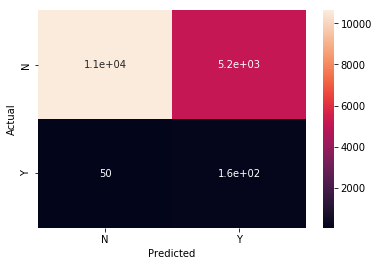

Recall Score:  0.7572815533980582
Precision Score:  0.029356417011667295
Area Under Curve:  0.7915542158821399


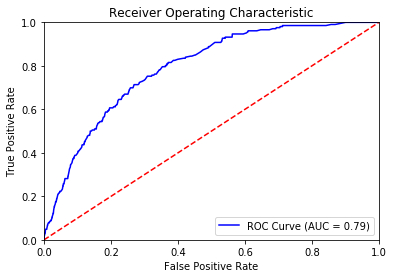

In [27]:
confusion_matrix = pd.crosstab(OBU['SAR'], OBU['pred'], rownames=['Actual'], 
                              colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ', metrics.accuracy_score(OBU['SAR'], OBU['pred']))
plt.show()

recall_score = metrics.recall_score(OBU['SAR'], OBU['pred'], pos_label='Y')
precision_score = metrics.precision_score(OBU['SAR'], OBU['pred'], pos_label='Y')
print('Recall Score: ', recall_score)
print('Precision Score: ', precision_score)


print('Area Under Curve: ', roc_auc_score(OBU['SAR'], OBU['pred_proba']))

fpr, tpr, threshold = metrics.roc_curve(OBU['SAR'], OBU['pred_proba'], pos_label='Y')
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 2.2 全部資料跑模型，確認變數係數

In [30]:
X_train, X_test = X, y

# class_weight='balanced'
logistic_regression = LogisticRegression(solver='liblinear', class_weight='balanced')
logistic_regression.fit(X_train, y_train)

# Weights & Intercept
print('Intercept: ', logistic_regression.intercept_, '\n')

for i in range(len(logistic_regression.coef_[0])):
    print(X.columns[i], ': ', logistic_regression.coef_[0][i])
print('----------------------------------')
# Search sklearn.feature_selection


# AIC
# 待定: 計算residual的時候 y hat應該用probability 還是 outcome(0, 1)
y_test_trans = [1 if i=='Y' else 0 for i in y_test]
resid = y_test_trans - logistic_regression.predict_proba(X_test)[:, 1]
sse = sum(resid**2)
k = len(X_test.columns) #number of variables
AIC = 2*k - 2*np.log(sse) # k: number of parameters
print('AIC: ', AIC) # the smaller the better

# BIC
n = len(X_test) #the number of observations
BIC = n*np.log(sse/n) - k*np.log(n) # k: number of parameters
print('BIC: ', BIC)

Intercept:  [-3.58032608] 

CMFCUS1_FINANCIAL_ACT :  1.498346349885179
IX_FG :  1.13337880592972
EB_FG :  0.047498708362128675
CMFCUS1_ADR_CNT_THR_2 :  0.1973944153228511
REL_ADVERS_COUNT_THR_1 :  3.560803841675186
AMT_RANGE :  0.39690861573606573
OBU_ANNUAL_INCOME :  0.1386544011820941
CMFCUS1_PURPOSE_E :  0.5110452908965969
CMFCUS1_PURPOSE_NA_TYPE :  0.46805801029192445
LN_TYP_NA_TYPE :  -1.9710419049196
CONFIRM_TYPE_1 :  0.9747241891350192
CORP_TYPE_4 :  -1.5061437883660274
----------------------------------
AIC:  11.19373088247378
BIC:  -5431.048403294713


#### Appendix

In [37]:
OBU.groupby(['FINAL_CRR', 'SAR'])['SAR'].count()

FINAL_CRR  SAR
H          N      7150
           Y       206
L          N       862
M          N      7777
Name: SAR, dtype: int64